In [1]:
%pip install javalang transformers tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install javalang transformers tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install javalang transformers tensorflow  torch

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import numpy as np
import pandas as pd
import javalang
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import AutoTokenizer, TFAutoModel
import torch

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Tokenización javalang
def tokenize_javalang(code):
    try:
        tokens = list(javalang.tokenizer.tokenize(code))
        return [token.value for token in tokens]
    except:
        return []

# Tokenización y padding para LSTM y CNN
def get_sequences(codes, tokenizer, maxlen):
    seqs = tokenizer.texts_to_sequences(codes)
    return pad_sequences(seqs, maxlen=maxlen, padding='post', truncating='post')

# Embedding CodeBERT (usa pytorch backend)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
codebert_tokenizer = AutoTokenizer.from_pretrained('microsoft/codebert-base')
codebert_model = TFAutoModel.from_pretrained('microsoft/codebert-base')

def codebert_embed(code, max_length=256):
    inputs = codebert_tokenizer(
        code, return_tensors='tf', padding='max_length', truncation=True, max_length=max_length
    )
    outputs = codebert_model(**inputs)
    emb = outputs.last_hidden_state[:, 0, :]  # [CLS] token embedding
    return emb.numpy().squeeze()  # (768,)

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at microsoft/codebert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [6]:
# --- Cargar tus datos de pares ---
# (Adapta según tu estructura)
base_dir = "./conplag_dataset/versions/version_2"
carpetas_pares = [os.path.join(base_dir, carpeta) for carpeta in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, carpeta))]

codes_1, codes_2 = [], []
nombres_1, nombres_2 = [], []

for carpeta in carpetas_pares:
    archivos = os.listdir(carpeta)
    if len(archivos) != 2:
        continue
    archivo1 = os.path.join(carpeta, archivos[0])
    archivo2 = os.path.join(carpeta, archivos[1])
    with open(archivo1, 'r', encoding='utf-8') as f1, open(archivo2, 'r', encoding='utf-8') as f2:
        codes_1.append(f1.read())
        codes_2.append(f2.read())
        nombres_1.append(os.path.splitext(archivos[0])[0])
        nombres_2.append(os.path.splitext(archivos[1])[0])

In [7]:
# --- Construir vocabulario para LSTM/CNN ---
all_tokens = [' '.join(tokenize_javalang(code)) for code in codes_1 + codes_2]
keras_tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
keras_tokenizer.fit_on_texts(all_tokens)
maxlen = 256

In [8]:
# Prepara secuencias de tokens
tokens_1 = [' '.join(tokenize_javalang(code)) for code in codes_1]
tokens_2 = [' '.join(tokenize_javalang(code)) for code in codes_2]
X1_seq = get_sequences(tokens_1, keras_tokenizer, maxlen)
X2_seq = get_sequences(tokens_2, keras_tokenizer, maxlen)

In [9]:
# Prepara embeddings CodeBERT (puede tardar)
print("Generando embeddings de CodeBERT (esto puede tardar unos minutos)...")
X1_cb = np.stack([codebert_embed(code) for code in codes_1])
X2_cb = np.stack([codebert_embed(code) for code in codes_2])
print("Listo.")


Generando embeddings de CodeBERT (esto puede tardar unos minutos)...
Listo.


In [10]:
# --- Etiquetas ---
data_dir = "./conplag_dataset/versions/"
labels_csv = os.path.join(data_dir, "labels.csv")
labels_df = pd.read_csv(labels_csv)
# Asegúrate de que las columnas 'sub1', 'sub2' y 'verdict' existen en el CSV
labels_dict = {(str(row['sub1']), str(row['sub2'])): row['verdict'] for _, row in labels_df.iterrows()}

y = []
for name1, name2 in zip(nombres_1, nombres_2):
    label = labels_dict.get((name1, name2), labels_dict.get((name2, name1), None))
    if label is None:
        print(f"Warning: No label found for pair ({name1}, {name2})")
        label = 0
    y.append(label)
y = np.array(y)

# Dividir el DataSet (Train/Val/Test)

In [11]:
from sklearn.model_selection import train_test_split

 # Split 80% train/val, 20% test
X1_seq_temp, X1_seq_test, X2_seq_temp, X2_seq_test, X1_cb_temp, X1_cb_test, X2_cb_temp, X2_cb_test, y_temp, y_test = train_test_split(
     X1_seq, X2_seq, X1_cb, X2_cb, y, test_size=0.2, random_state=42, stratify=y
 )

# # Split de validación (10% del total, es 12.5% de train/val)
X1_seq_train, X1_seq_val, X2_seq_train, X2_seq_val, X1_cb_train, X1_cb_val, X2_cb_train, X2_cb_val, y_train, y_val = train_test_split(
     X1_seq_temp, X2_seq_temp, X1_cb_temp, X2_cb_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp
 )



In [12]:
def resumen_clases(y, nombre):
    _, counts = np.unique(y, return_counts=True)
    print(f"{nombre}: Plagio = {np.sum(y==1)}, No Plagio = {np.sum(y==0)}, Total = {len(y)}")

# Analiza la proporción original en cada split
resumen_clases(y_train, "Entrenamiento (original)")
resumen_clases(y_val,   "Validación (original)")
resumen_clases(y_test,  "Test (original)")


Entrenamiento (original): Plagio = 176, No Plagio = 461, Total = 637
Validación (original): Plagio = 25, No Plagio = 66, Total = 91
Test (original): Plagio = 50, No Plagio = 133, Total = 183


In [14]:
from sklearn.model_selection import train_test_split
import numpy as np

# (Usa tus propios arrays de entrada aquí)
# Por ejemplo: X1_seq, X2_seq, X1_cb, X2_cb, y

# Split 80% train/val, 20% test
X1_seq_temp, X1_seq_test, X2_seq_temp, X2_seq_test, X1_cb_temp, X1_cb_test, X2_cb_temp, X2_cb_test, y_temp, y_test = train_test_split(
    X1_seq, X2_seq, X1_cb, X2_cb, y, test_size=0.2, random_state=42, stratify=y
)

# Split de validación (10% del total, es 12.5% de train/val)
X1_seq_train, X1_seq_val, X2_seq_train, X2_seq_val, X1_cb_train, X1_cb_val, X2_cb_train, X2_cb_val, y_train, y_val = train_test_split(
    X1_seq_temp, X2_seq_temp, X1_cb_temp, X2_cb_temp, y_temp,
    test_size=0.125, random_state=42, stratify=y_temp
)

# Encuentra índices de plagio y no plagio en el set de entrenamiento
plag_idx = np.where(y_train == 1)[0]
nonplag_idx = np.where(y_train == 0)[0]

n_plag = len(plag_idx)
n_nonplag_needed = int(n_plag * 2.5)

np.random.seed(42)
if len(nonplag_idx) > n_nonplag_needed:
    selected_nonplag_idx = np.random.choice(nonplag_idx, size=n_nonplag_needed, replace=False)
else:
    selected_nonplag_idx = nonplag_idx

# Combina y mezcla
final_idx = np.concatenate([plag_idx, selected_nonplag_idx])
np.random.shuffle(final_idx)

# Filtra tus arrays de entrenamiento
X1_seq_train_bal = X1_seq_train[final_idx]
X2_seq_train_bal = X2_seq_train[final_idx]
X1_cb_train_bal  = X1_cb_train[final_idx]
X2_cb_train_bal  = X2_cb_train[final_idx]
y_train_bal      = y_train[final_idx]



In [15]:
def resumen_clases(y, nombre):
    _, counts = np.unique(y, return_counts=True)
    print(f"{nombre}: Plagio = {np.sum(y==1)}, No Plagio = {np.sum(y==0)}, Total = {len(y)}")

resumen_clases(y_train_bal, "Entrenamiento (balanceado)")
resumen_clases(y_val,       "Validación (original)")
resumen_clases(y_test,      "Test (original)")


Entrenamiento (balanceado): Plagio = 176, No Plagio = 440, Total = 616
Validación (original): Plagio = 25, No Plagio = 66, Total = 91
Test (original): Plagio = 50, No Plagio = 133, Total = 183


In [16]:
from sklearn.utils import class_weight
import numpy as np

# y_train debe ser el vector de etiquetas de tu set de entrenamiento
class_weights_arr = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: class_weights_arr[i] for i in range(len(class_weights_arr))}
print("Pesos de clase:", class_weights)


Pesos de clase: {0: np.float64(0.6908893709327549), 1: np.float64(1.8096590909090908)}


# Construccion del Modelo usando Keras

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Dense, Concatenate, Dropout, Lambda
from tensorflow.keras.models import Model

vocab_size = 10000
embed_dim = 128

# --- LSTM branch ---
def lstm_branch():
    inp = Input(shape=(maxlen,))
    x = Embedding(vocab_size, embed_dim, mask_zero=True)(inp)
    x = LSTM(16)(x)
    return Model(inp, x, name="LSTM_Branch")

# --- CNN branch ---
def cnn_branch():
    inp = Input(shape=(maxlen,))
    x = Embedding(vocab_size, embed_dim, mask_zero=True)(inp)
    #x = Conv1D(32, 5, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Conv1D(16, 3, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    return Model(inp, x, name="CNN_Branch")

# --- CodeBERT branch ---
def codebert_branch():
    inp = Input(shape=(768,))
    x = Dense(32, activation='relu')(inp)
    return Model(inp, x, name="CodeBERT_Branch")

# Instancia de las ramas
lstm = lstm_branch()
cnn = cnn_branch()
codebert = codebert_branch()

# Inputs para los dos códigos (pares)
in_lstm_1 = Input(shape=(maxlen,))
in_lstm_2 = Input(shape=(maxlen,))
in_cnn_1  = Input(shape=(maxlen,))
in_cnn_2  = Input(shape=(maxlen,))
in_cb_1   = Input(shape=(768,))
in_cb_2   = Input(shape=(768,))

# Salidas de cada rama
out_lstm_1 = lstm(in_lstm_1)
out_lstm_2 = lstm(in_lstm_2)
out_cnn_1  = cnn(in_cnn_1)
out_cnn_2  = cnn(in_cnn_2)
out_cb_1   = codebert(in_cb_1)
out_cb_2   = codebert(in_cb_2)

# Integración de features (feature fusion)
feat_1 = Concatenate()([out_lstm_1, out_cnn_1, out_cb_1])
feat_2 = Concatenate()([out_lstm_2, out_cnn_2, out_cb_2])
merged = Lambda(lambda x: tf.abs(x[0] - x[1]))([feat_1, feat_2])

# Clasificación
x = Dense(32, activation='relu')(merged)
#x = Dropout(0.8)(x)
x = Dense(16, activation='relu')(x)
#x = Dropout(0.4)(x)
out = Dense(1, activation='sigmoid')(x)

model = Model(
    [in_lstm_1, in_lstm_2, in_cnn_1, in_cnn_2, in_cb_1, in_cb_2],
    out
)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


c:\Python312\Lib\site-packages\keras\src\layers\layer.py:965: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_Branch         │ (None, 16)        │  1,289,280 │ input_layer_3[0]… │
│ (Functional)        │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CNN_Branch          │ (None, 16)        │  1,286,160 │ input_layer_5[0]… │
│ (Functional)        │                   │            │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CodeBERT_Branch     │ (None, 32)        │     24,608 │ input_layer_7[0]… │
│ (Functional)        │                   │            │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ LSTM_Branch[0][0… │
│ (Concatenate)       │                   │            │ CNN_Branch[0][0], │
│                     │                   │            │ CodeBERT_Branch[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64)        │          0 │ LSTM_Branch[1][0… │
│ (Concatenate)       │                   │            │ CNN_Branch[1][0], │
│                     │                   │            │ CodeBERT_Branch[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 64)        │          0 │ concatenate[0][0… │
│                     │                   │            │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │        528 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         17 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,602,673 (9.93 MB)

 Trainable params: 2,602,673 (9.93 MB)

 Non-trainable params: 0 (0.00 B)

# Entrenamiento 

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_accuracy',  # Monitorea la precisión de validación
    patience=5,          # Epochs a esperar sin mejora
    restore_best_weights=True
)

In [19]:
history = model.fit(
    [X1_seq_train, X2_seq_train, X1_seq_train, X2_seq_train, X1_cb_train, X2_cb_train],
    y_train,
    validation_data=([X1_seq_val, X2_seq_val, X1_seq_val, X2_seq_val, X1_cb_val, X2_cb_val], y_val),
    batch_size=32,
    epochs=30,
    class_weight={0:1, 1:4},  # Ajusta si es necesario
    shuffle=True,
    callbacks=[early_stop]
)


Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.6044 - loss: 1.2994 - val_accuracy: 0.6374 - val_loss: 0.6882
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.6904 - loss: 1.2568 - val_accuracy: 0.7363 - val_loss: 0.6604
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.8623 - loss: 1.1754 - val_accuracy: 0.8352 - val_loss: 0.5864
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.9229 - loss: 0.9899 - val_accuracy: 0.8242 - val_loss: 0.5065
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9422 - loss: 0.6861 - val_accuracy: 0.7802 - val_loss: 0.5124
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.9580 - loss: 0.4862 - val_accuracy: 0.7582 - val_loss: 0.5176
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.9826 - loss: 0.2569 - val_accuracy: 0.8022 - val_loss: 0.5439
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9977 - loss: 0.1653 - val_accuracy: 0.

In [20]:
# Evalúa sobre el set de test
test_metrics = model.evaluate([X1_seq_test, X2_seq_test, X1_seq_test, X2_seq_test, X1_cb_test, X2_cb_test], y_test)
print("Test metrics:", test_metrics)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8183 - loss: 0.5904
Test metrics: [0.592319905757904, 0.8032786846160889]


# Confussion Matrix y Gráficas

c:\Python312\Lib\site-packages\keras\src\layers\layer.py:965: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step
Matriz de confusión:
[[117  16]
 [ 20  30]]


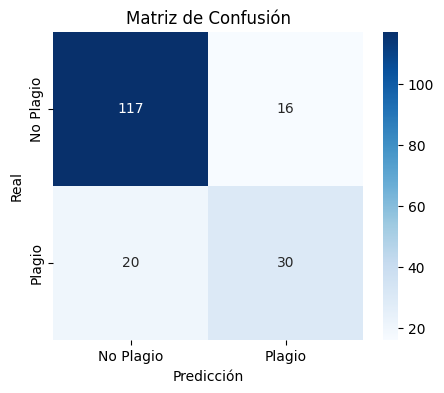

Reporte de clasificación:
              precision    recall  f1-score   support

   No Plagio       0.85      0.88      0.87       133
      Plagio       0.65      0.60      0.62        50

    accuracy                           0.80       183
   macro avg       0.75      0.74      0.75       183
weighted avg       0.80      0.80      0.80       183



In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Haz las predicciones (threshold 0.5 para binario)
y_pred_proba = model.predict([
    X1_seq_test, X2_seq_test, X1_seq_test, X2_seq_test, X1_cb_test, X2_cb_test
])
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
print(cm)

# Visualización de la matriz
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Plagio', 'Plagio'], 
            yticklabels=['No Plagio', 'Plagio'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

# Reporte de clasificación
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['No Plagio', 'Plagio']))


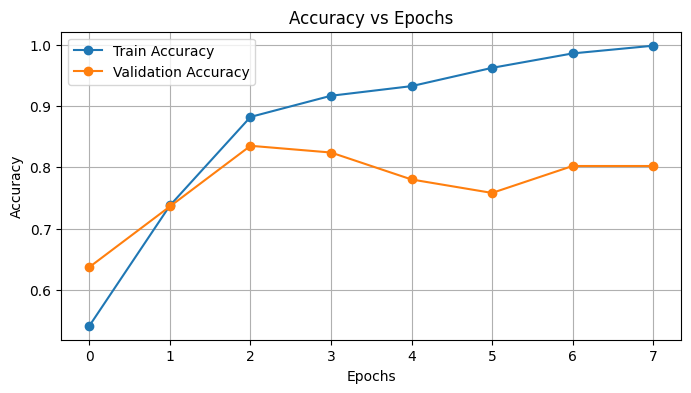

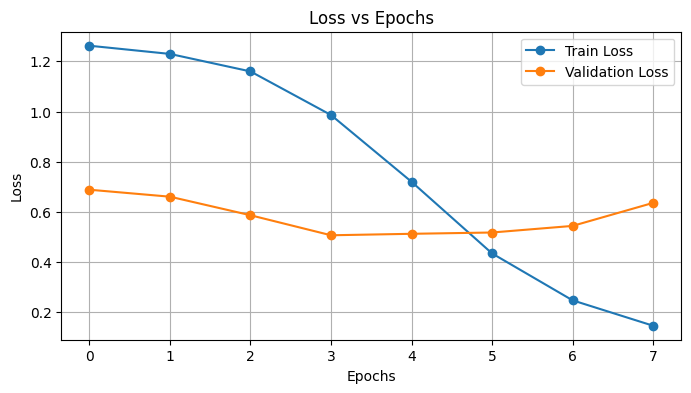

In [22]:
# Accuracy vs Epochs
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Loss vs Epochs
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()
